# Kaggle House Price Prob.

2018.08.04.Sat. Teddy

for Google Machine learning study

*******************************************************

# Content
### 1. Data Skimming

    1-0. Data collect
    1-1. Data load
    1-2. Data Skimming


### 2. Data Processing

    2-1. Drop
    2-2. Fill NAs
    2-3. Editing ( Adding, Editing, Binning etc..)
    
    
### 3. Model & Evaluation

    3-1 Pipelining
    3-2 Model Selection & Eval
    3-3 Result
    
    
*******************************************************


In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


## 1. Data Skimming

### 1-1 Data load

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

### 1-2 Data Skimming (Visualization)

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# detailed
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

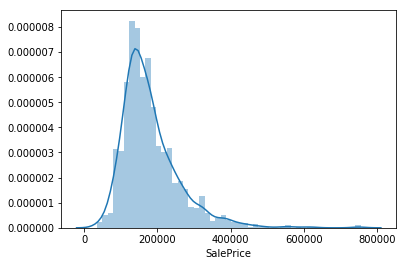

In [5]:
sns.distplot(train["SalePrice"])

In [6]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [7]:
# 1-4 detailed Features & Relationship with variables

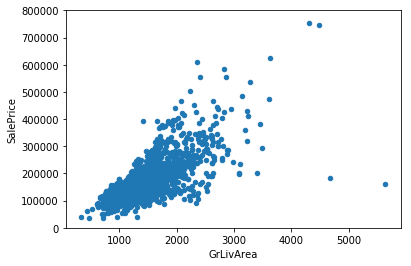

In [8]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea' ## 다른 feature들을 넣고 확인해 보면 됨, 
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [9]:
train[var].dtype # pandas , describe, dtype etc 

dtype('int64')

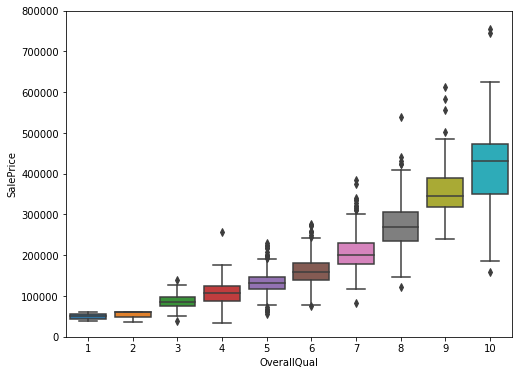

In [10]:
#box plot overallqual/saleprice
## boxplot : http://www.physics.csbsju.edu/stats/box2.html
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

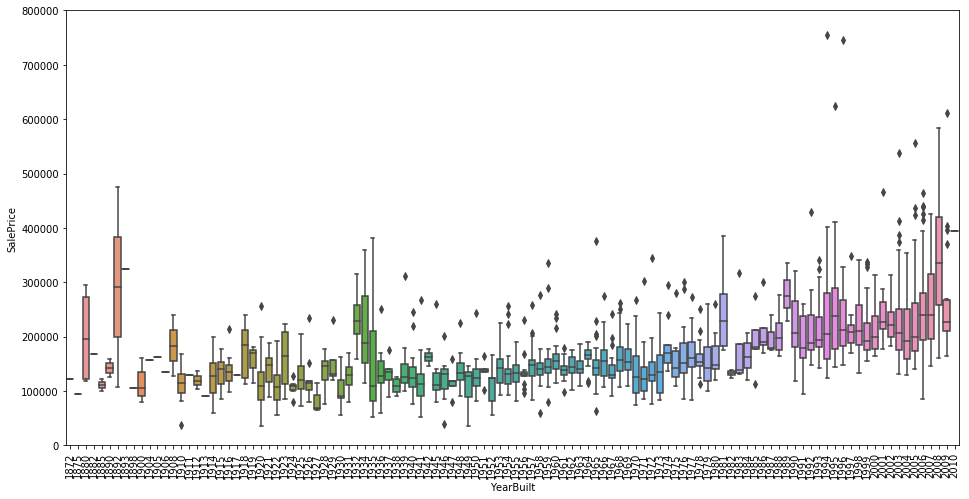

In [11]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

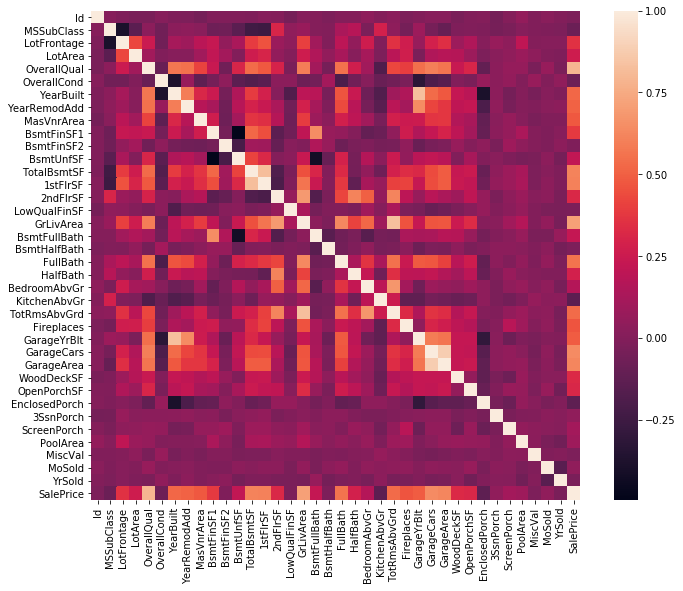

In [12]:
# Let's see at a glance

# correlation matrix
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);
## 빠져있는것들은 !

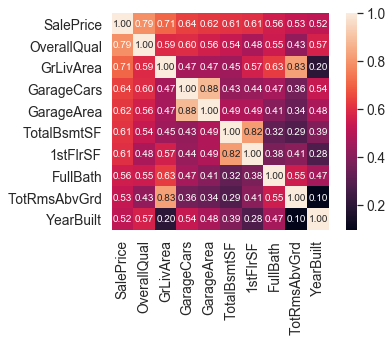

In [13]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Check point
1. overall Qual, GrLivArea, TotalBsmtSF
2. GarageCars & GarageArea
3. TotalBsmtSF and 1stFloor
4. Full Bath
5. TotRmsAbvGrd & GrLivArea
6. Year Built (time-series)

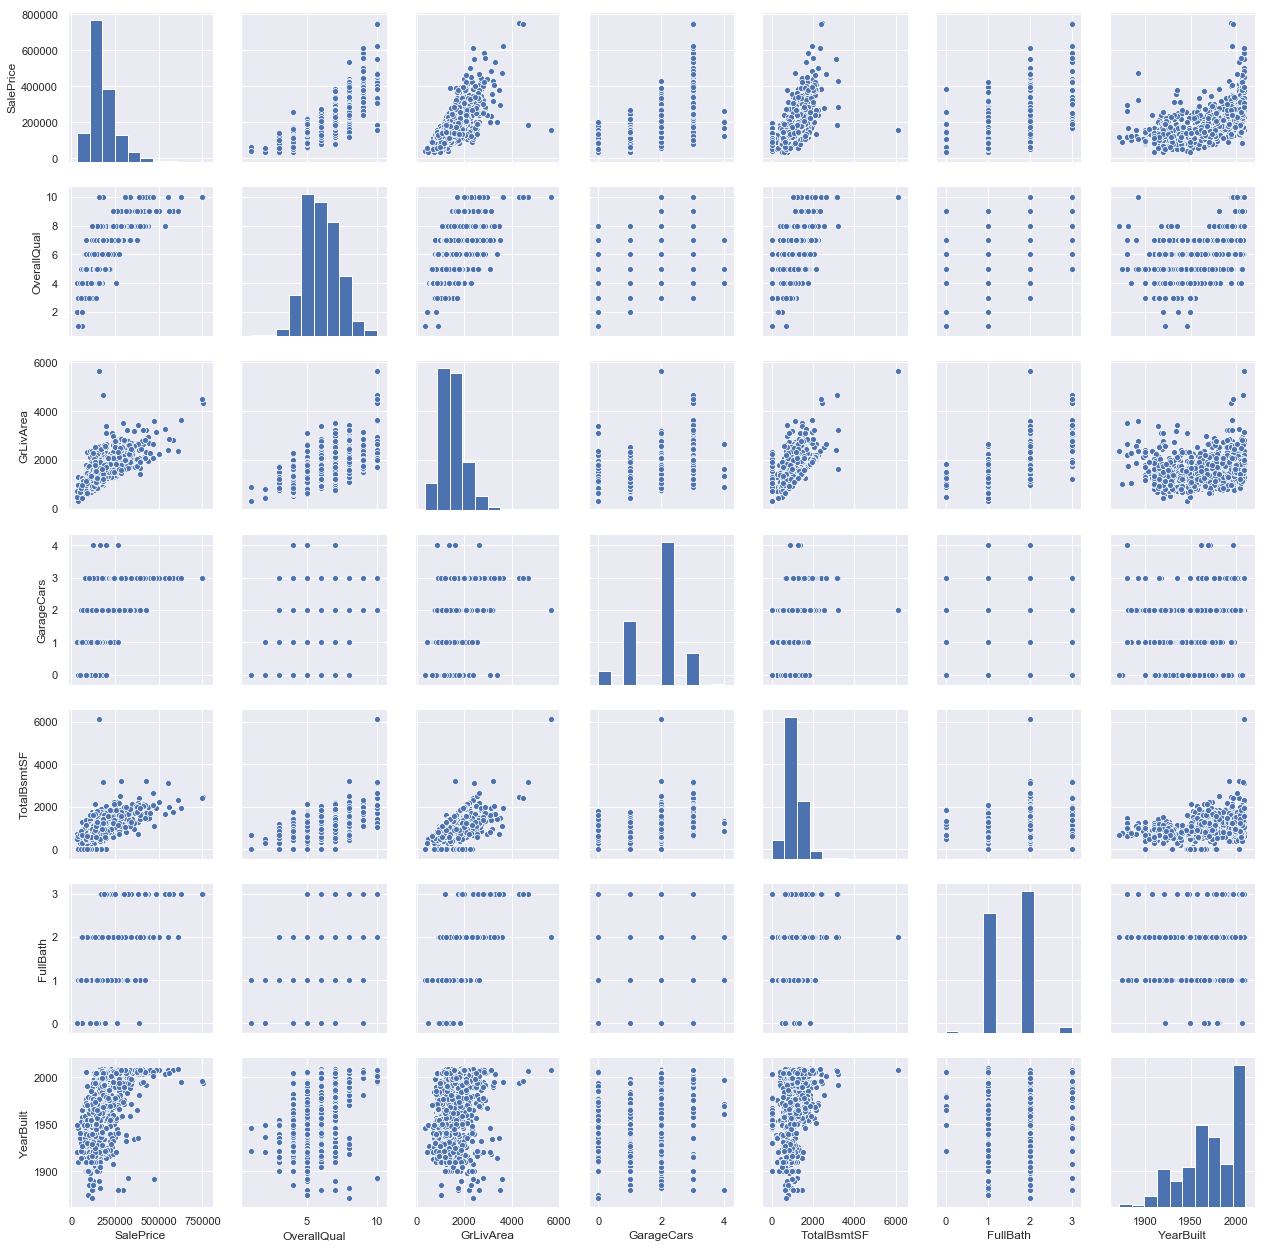

In [14]:
# scatterplot
sns.set()
cols = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(train[cols],size=2.5)
plt.show()

## 2. Data Processing

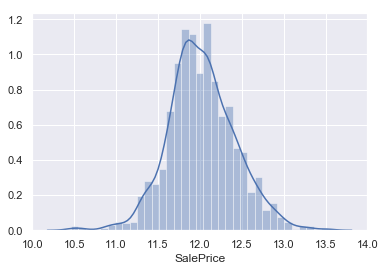

In [15]:
train_labels = train.pop('SalePrice')
train_labels = np.log(train_labels)
sns.distplot(train_labels)

In [16]:
features = pd.concat([train, test], keys=['train', 'test'])
features.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
test 1454  2915         160       RM         21.0     1936   Pave   NaN   
     1455  2916         160       RM         21.0     1894   Pave   NaN   
     1456  2917          20       RL        160.0    20000   Pave   NaN   
     1457  2918          85       RL         62.0    10441   Pave   NaN   
     1458  2919          60       RL         74.0     9627   Pave   NaN   

          LotShape LandContour Utilities      ...       ScreenPorch PoolArea  \
test 1454      Reg         Lvl    AllPub      ...                 0        0   
     1455      Reg         Lvl    AllPub      ...                 0        0   
     1456      Reg         Lvl    AllPub      ...                 0        0   
     1457      Reg         Lvl    AllPub      ...                 0        0   
     1458      Reg         Lvl    AllPub      ...                 0        0   

          PoolQC  Fence MiscFeature MiscVal MoSold  YrSold  SaleType  \
test 1454    NaN    NaN         NaN       0      6    2006        WD   
     1455    NaN    NaN         NaN       0      4    2006        WD   
     1456    NaN    NaN         NaN       0      9    2006        WD   
     1457    NaN  MnPrv        Shed     700      7    2006        WD   
     1458    NaN    NaN         NaN       0     11    2006        WD   

           SaleCondition  
test 1454         Normal  
     1455        Abnorml  
     1456        Abnorml  
     1457         Normal  
     1458         Normal  

[5 rows x 80 columns]

In [17]:
features.shape

(2919, 80)

In [18]:
# pandas : https://pandas.pydata.org/pandas-docs/stable/merging.html

### 2-1 drop

In [19]:
# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

In [20]:
features.shape

(2919, 56)

### 2-2 Fill NAs

In [21]:
# isnull?
num_null = features.isnull().sum()
num_null[num_null > 0].sort_values(ascending=False)

Alley           2721
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
TotalBsmtSF        1
Electrical         1
Exterior2nd        1
Exterior1st        1
KitchenQual        1
GarageCars         1
SaleType           1
dtype: int64

In [22]:
## 많이 빠졌다
# numeric type
cols=["TotalBsmtSF", "GarageCars"]
for col in cols:
    features[col].fillna(0, inplace=True)

#string type
cols=["Alley", "FireplaceQu", "GarageType","GarageFinish","GarageQual", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols:
    features[col].fillna('NA', inplace=True)

##1~ X개 빠진거는
#string type(small) - 가장 많이 나온 값을 넣자
cols=["MSZoning", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols:
    features[col].fillna(features[col].mode()[0], inplace=True)

#numeric type(small) - 평균 값을 쓰자
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

In [23]:
# still?
num_null = features.isnull().sum()
num_null[num_null > 0].sort_values(ascending=False)

Series([], dtype: int64)

### 2-3 Editing

In [24]:
# convert data type (categorical) - string으로 만들자
cols=['MSSubClass','OverallCond','KitchenAbvGr','YrSold','MoSold']
for col in cols:
    features[col] = features[col].astype(str)


In [25]:
k = pd.concat([features['TotalBsmtSF'],features['1stFlrSF'],features['2ndFlrSF']],keys=[1,2,3],axis=1)
k.head(10)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor full
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)


In [26]:
#standardized
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean()) / numeric_features.std()

In [27]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)


In [28]:
# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [29]:
features.shape

(2919, 284)

# 3. Model & Evaluation

### 3-1 pipeline

In [30]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [31]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].select_dtypes(include=[np.number]).drop('Id', axis=1).values

In [32]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)


In [33]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

### 3-2 Model Selection & Evaluation

In [34]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .001, .05, .5, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.001, 0.05, 0.5, 0.99], max_iter=5000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)
R2: 0.7843618041880426
RMSE: 0.16666068475000143
Test
R2: 0.8642613227064195
RMSE: 0.12690198006451334


In [35]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.13)


In [36]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.9612678700949794
RMSE: 0.07645897737140267
Test
R2: 0.9104854504523666
RMSE: 0.1032717089032673
Accuracy: 0.86 (+/- 0.05)


In [37]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

In [38]:
LassoTest = linear_model.LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10],max_iter=5000).fit(x_train, y_train)
train_test(LassoTest, x_train, x_test, y_train, y_test)

LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
    cv=None, eps=0.001, fit_intercept=True, max_iter=5000, n_alphas=100,
    n_jobs=1, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)
R2: 0.8890537620325873
RMSE: 0.1252581423485814
Test
R2: 0.8986609376054957
RMSE: 0.1088448451697659


In [39]:
scores = cross_val_score(LassoTest, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.13)


## Result

In [40]:
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)
LS_model = LassoTest.fit(train_features_st,train_labels)

In [41]:
Final_labels = (np.exp(GB_model.predict(test_features)) +
                np.exp(ENST_model.predict(test_features_st)) +
                np.exp(LS_model.predict(test_features_st))) / 3

In [42]:
Final_labels

array([115143.30848093, 144396.01689475, 177439.86166198, ...,
       161361.32566574, 121428.33724924, 231899.4669635 ])

# Submit the result

In [43]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': Final_labels}).to_csv('my_prediction.csv', index =False)